In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from bioinfokit.visuz import cluster
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from mlxtend.evaluate import bias_variance_decomp
from sklearn.metrics import roc_curve, auc

In [2]:
heart_df = pd.read_csv('/Users/mucheng/Datasets/heart.csv')
cat_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
heart_df[cat_columns] = heart_df[cat_columns].apply(LabelEncoder().fit_transform)
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1,1,140,289,0,1,172,0,0.0,2,0
1,49,0,2,160,180,0,1,156,0,1.0,1,1
2,37,1,1,130,283,0,2,98,0,0.0,2,0
3,48,0,0,138,214,0,1,108,1,1.5,1,1
4,54,1,2,150,195,0,1,122,0,0.0,2,0


In [316]:
heart_df.shape

(918, 12)

In [315]:
heart_df['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

## Apply PCA

### Standardize the Data

In [3]:
X = heart_df.drop("HeartDisease", 1)
y = heart_df.HeartDisease

X = StandardScaler().fit_transform(X)

X_pca = PCA().fit(X)
explained_variance = X_pca.explained_variance_ratio_
print(explained_variance)
print(np.cumsum(explained_variance))

[0.25139665 0.1330889  0.10512913 0.09088956 0.07916761 0.07695206
 0.07333057 0.05675535 0.05066628 0.04557194 0.03705196]
[0.25139665 0.38448554 0.48961467 0.58050423 0.65967184 0.73662391
 0.80995448 0.86670982 0.9173761  0.96294804 1.        ]


/var/folders/dw/_3hp0rfn7rngzth_1dc9rh280000gn/T/ipykernel_10985/3724675732.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = heart_df.drop("HeartDisease", 1)


In [207]:
# X_pca.components_ == eigenvalues

### Scree Plot

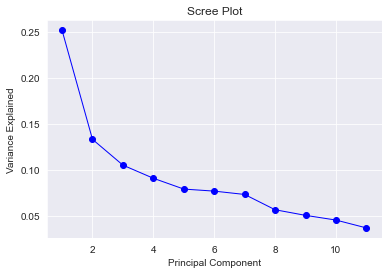

In [208]:

# # num_components = X_pca.n_features_
# pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
# cluster.screeplot(obj=[pc_list, X_pca.explained_variance_ratio_])


# pca = PCA()
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)
# explained_variance = pca.explained_variance_ratio_
# explained_variance 


pca_values = np.arange(X_pca.n_components_) + 1
plt.plot(pca_values, X_pca.explained_variance_ratio_, 'o-', linewidth=1, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Arrows Based on Eigenvalues and Eigenvectors
Graph is shown in png file

In [209]:
pca_loadings = X_pca.components_
pca_scores = PCA().fit_transform(X)
cluster.biplot(cscore=pca_scores, loadings=pca_loadings, labels=heart_df.columns.values, var1=round(X_pca.explained_variance_ratio_[0]*100, 2),
    var2=round(X_pca.explained_variance_ratio_[1]*100, 2))

## Implement Decision Tree Model

## Build A Decision Tree
Please note the following two blocks of code demonstrate how to build a decision tree \
are borrowed from "Decision Tree Classification in Python (from scratch!)" created by Normalized Nerd, https://www.youtube.com/watch?v=sgQAhG5Q7iY  \

Only for study purpose and comparing with other models

In [236]:
 class DT_Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold ## helps to split node
        self.left = left
        self.right = right
        self.info_gain = info_gain ## find the best split
        self.value = value
   

In [237]:
class DT_Model():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree ''' 
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X) 
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return DT_Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return DT_Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y, "gini")
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        ''' function to split the data '''
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode="entropy"):
        ''' function to compute information gain '''
        
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    
    def entropy(self, y):
        ''' function to compute entropy '''
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = (y == cls).mean()
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        ''' function to compute gini index '''
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        ''' function to compute leaf node '''
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        ''' function to train the tree '''
        
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):
        ''' function to predict new dataset '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        ''' function to predict a single data point '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)



In [263]:
# heart_X = heart_df.iloc[:, :-1].values
# heart_Y = heart_df.iloc[:, -1].values.reshape(-1,1)


heart_X = X
heart_Y = y.values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(heart_X, heart_Y, test_size=.2, random_state=41)



# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=.2, random_state=41)

In [264]:
classifier = DT_Model(min_samples_split=2, max_depth=2)
# classifier
classifier.fit(X_train,Y_train)
classifier.print_tree()


X_10 <= -0.5960781286477971 ? 0.20912139163151178
 left:X_2 <= -0.8169949500039223 ? 0.02723246990972128
  left:X_1 <= -1.9381632242764861 ? 0.008223143153685997
    left:1.0
    right:1.0
  right:X_7 <= -0.03180670686239484 ? 0.060743801652892504
    left:1.0
    right:1.0
 right:X_4 <= -1.8184347672830603 ? 0.07679893981203073
  left:X_5 <= -0.5513413395776455 ? 0.14013840830449814
    left:0.0
    right:1.0
  right:X_8 <= -0.8235562959371365 ? 0.030195305943106543
    left:0.0
    right:0.0


In [265]:
y_predictions = classifier.predict(X_test)
accuracy_score(Y_test, y_predictions)

0.7880434782608695

In [266]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7847296494355318

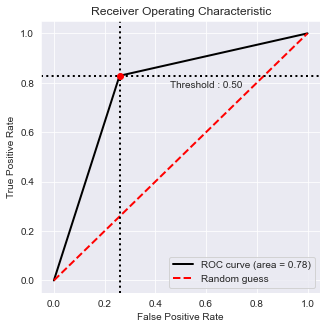

In [267]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(Y_test, y_predictions, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()


## Test Built-in Classification Models

### No.1 Use Decision Tree Classfier

### Baseline Decision Tree 
'ccp_alpha': 0.0, \
'class_weight': None, \
'criterion': 'gini', \
'max_depth': None, how deep the tree can be. \
'max_features': None,\
'max_leaf_nodes': None, \
'min_impurity_decrease': 0.0, \
'min_samples_leaf': 1, \
'min_samples_split': 2, It helps to stop tree growth and control overfitting \
'min_weight_fraction_leaf': 0.0, \
'random_state': None, \
'splitter': 'best' 


In [246]:
DT_clf = DecisionTreeClassifier()
DT_clf.get_params()


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [255]:

DT_clf = DT_clf.fit(X_train,Y_train)
baseline_DT_y_pred = DT_clf.predict(X_test)
accuracy_score(Y_test, baseline_DT_y_pred)

0.8152173913043478

In [256]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, baseline_DT_y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8149732620320856

In [314]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, baseline_DT_y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area Under the Curve: ", roc_auc)

#Calculate F1 Value
print(classification_report(Y_test, baseline_DT_y_pred))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(DT_for_ptuning, X_train, Y_train, X_test, Y_test, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
V1_DT_GS_confusion_matrix = calculate_confusion_matrix(Y_test, baseline_DT_y_pred)
V1_DT_GS_confusion_matrix

Area Under the Curve:  0.8149732620320856
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        85
           1       0.84      0.82      0.83        99

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184

MSE: 0.4965884924385634 Bias: 71.08603260869565 Variance: 0.11025135869565217


array([[81, 18],
       [16, 69]])

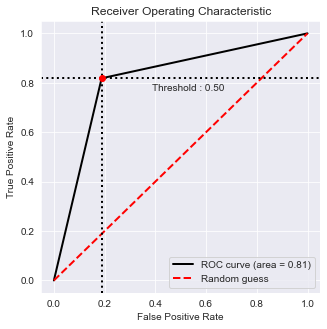

In [257]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(Y_test, baseline_DT_y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()


### Baseline Model

In [323]:
# Preparing GridSearch for data set:
b_DT_parameters = {
    
    'criterion': ['gini'],
    'max_depth': [2], 
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [1.0],
    'min_weight_fraction_leaf': [0.0],
    'splitter': ['best']

}

b_DT_for_ptuning = DecisionTreeClassifier()
b_DT_GS = GridSearchCV(b_DT_for_ptuning,                    # model
                   param_grid = b_DT_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

b_DT_GS = b_DT_GS.fit(X_train, Y_train)
b_DT_GS_predictions = b_DT_GS.predict(X_test)



In [324]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, b_DT_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area Under the Curve: ", roc_auc)

#Calculate F1 Value
print(classification_report(Y_test, b_DT_GS_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(DT_for_ptuning, X_train, Y_train, X_test, Y_test, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
b_DT_GS_confusion_matrix = calculate_confusion_matrix(Y_test, b_DT_GS_predictions)
b_DT_GS_confusion_matrix

Area Under the Curve:  0.7544266191325015
              precision    recall  f1-score   support

           0       0.73      0.74      0.74        85
           1       0.78      0.77      0.77        99

    accuracy                           0.76       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.76      0.76      0.76       184

MSE: 0.4967063445179584 Bias: 70.87504239130433 Variance: 0.11151589673913043


array([[76, 23],
       [22, 63]])

### Calculate Confusion Matrix

In [13]:
#Input actual result and predictions
#Output confusion matrix

def calculate_confusion_matrix(actual, predicted):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for a_val, p_val in zip(actual, predicted):
        if a_val == p_val:
            if a_val == 1.0:
                tp += 1
            else:
                tn += 1
        else:
            if a_val == 1.0:
                fp += 1
            else:
                fn += 1
    confusion_matrix = [
        [tp, fp],
        [fn, tn]
    ]
    confusion_matrix = np.array(confusion_matrix)

    
    return confusion_matrix

### Try V1. with max_depth
increase max_depth from 2 to 4

### Variation 1. Max_Depth
The deeper the tree, the more splits it has and it captures more information about the data.

In [269]:
# Preparing GridSearch 
V1_DT_parameters = {
    
    'ccp_alpha': [0.0],
    'criterion': ['gini'],
    'max_depth': [4], 
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'min_weight_fraction_leaf': [0.0],
    'splitter': ['best']

}

DT_for_ptuning = DecisionTreeClassifier()
V1_DT_GS = GridSearchCV(DT_for_ptuning,                    # model
                   param_grid = V1_DT_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

V1_DT_GS = V1_DT_GS.fit(X_train, Y_train)
V1_DT_GS_predictions = V1_DT_GS.predict(X_test)



In [270]:
# print("Best max_depth:", V1_DT_GS.best_estimator_.get_params()['max_depth'])
print("Best max_depth:", V1_DT_GS.best_params_)


Best max_depth: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}


In [271]:

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, V1_DT_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area Under the Curve: ", roc_auc)

#Calculate F1 Value
print(classification_report(Y_test, V1_DT_GS_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(DT_for_ptuning, X_train, Y_train, X_test, Y_test, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
V1_DT_GS_confusion_matrix = calculate_confusion_matrix(Y_test, V1_DT_GS_predictions)
V1_DT_GS_confusion_matrix

Area Under the Curve:  0.8301841948900772
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        85
           1       0.81      0.92      0.86        99

    accuracy                           0.84       184
   macro avg       0.85      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184

MSE: 0.49670220935727794 Bias: 70.89723152173913 Variance: 0.11139116847826086


array([[91,  8],
       [22, 63]])

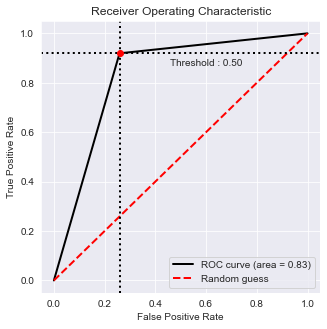

In [311]:

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, V1_DT_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(Y_test, V1_DT_GS_predictions, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

### Variation 2.  Minimum Samples Leaf

In [284]:
# Preparing GridSearch
V2_DT_parameters = {
    
    'ccp_alpha': [0.0],
    'criterion': ['gini'],
    'max_depth': [4], 
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'min_weight_fraction_leaf': [0.0],
    'splitter': ['best'],
    'max_features': [None] #,"auto","log2","sqrt",None],
}

DT_for_ptuning = DecisionTreeClassifier()
V2_DT_GS = GridSearchCV(DT_for_ptuning,                    # model
                   param_grid = V2_DT_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

V2_DT_GS = V2_DT_GS.fit(X_train, Y_train)
V2_DT_GS_predictions = V2_DT_GS.predict(X_test)

In [285]:
print("Best max_depth:", V2_DT_GS.best_params_)

Best max_depth: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}


In [286]:

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, V2_DT_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area Under the Curve: ", roc_auc)

#Calculate F1 Value
print(classification_report(Y_test, V2_DT_GS_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(DT_for_ptuning, X_train, Y_train, X_test, Y_test, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
V2_DT_GS_confusion_matrix = calculate_confusion_matrix(Y_test, V2_DT_GS_predictions)
V2_DT_GS_confusion_matrix

Area Under the Curve:  0.8301841948900772
              precision    recall  f1-score   support

           0       0.89      0.74      0.81        85
           1       0.81      0.92      0.86        99

    accuracy                           0.84       184
   macro avg       0.85      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184

MSE: 0.49672495274102085 Bias: 71.01709130434783 Variance: 0.1107625


array([[91,  8],
       [22, 63]])

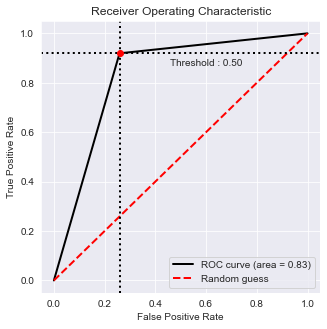

In [312]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, V2_DT_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(Y_test, V2_DT_GS_predictions, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

### Variation 3.  Minimum Samples Split

In [305]:
# Preparing GridSearch 
V3_DT_parameters = {
    'ccp_alpha': [0.0],
    'criterion': ['gini'],
    'max_depth': [4], 
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'min_weight_fraction_leaf': [0.0],
    'splitter': ['best'],
    "max_leaf_nodes": [10], #[None,10,20,30,40,50,60,70,80,90],
    'max_features': [None] #,"auto","log2","sqrt",None],
}

DT_for_ptuning = DecisionTreeClassifier()
V3_DT_GS = GridSearchCV(DT_for_ptuning,                    # model
                   param_grid = V3_DT_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

V3_DT_GS = V3_DT_GS.fit(X_train, Y_train)
V3_DT_GS_predictions = V3_DT_GS.predict(X_test)

In [306]:
print("Best max_depth:", V3_DT_GS.best_params_)

Best max_depth: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}


In [307]:

false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, V3_DT_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area Under the Curve: ", roc_auc)

#Calculate F1 Value
print(classification_report(Y_test, V3_DT_GS_predictions))

#Calculate MSE, Bias, and Variance Values
mse, bias, var = bias_variance_decomp(DT_for_ptuning, X_train, Y_train, X_test, Y_test, loss='mse', random_seed=1)
print("MSE: " + str(mse),"Bias: " + str(bias), "Variance: " + str(var))

#Compute Confusion Matrix
V3_DT_GS_confusion_matrix = calculate_confusion_matrix(Y_test, V3_DT_GS_predictions)
V3_DT_GS_confusion_matrix

Area Under the Curve:  0.854486036838978
              precision    recall  f1-score   support

           0       0.82      0.87      0.85        85
           1       0.88      0.84      0.86        99

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

MSE: 0.49662364130434783 Bias: 70.98577499999999 Variance: 0.11083138586956522


array([[83, 16],
       [11, 74]])

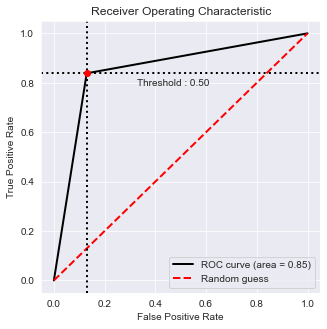

In [313]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, V3_DT_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(Y_test, V3_DT_GS_predictions, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()

In [308]:
V3_DT_GS_best_param = V3_DT_GS.best_estimator_


In [309]:
from sklearn import tree
def get_dt_graph(dt_classifier):
    fig = plt.figure(figsize=(25,20))
    _ = tree.plot_tree(dt_classifier,
                       feature_names=heart_df.columns,
                       class_names=['No Disease', "Disease"],
                       filled=True)

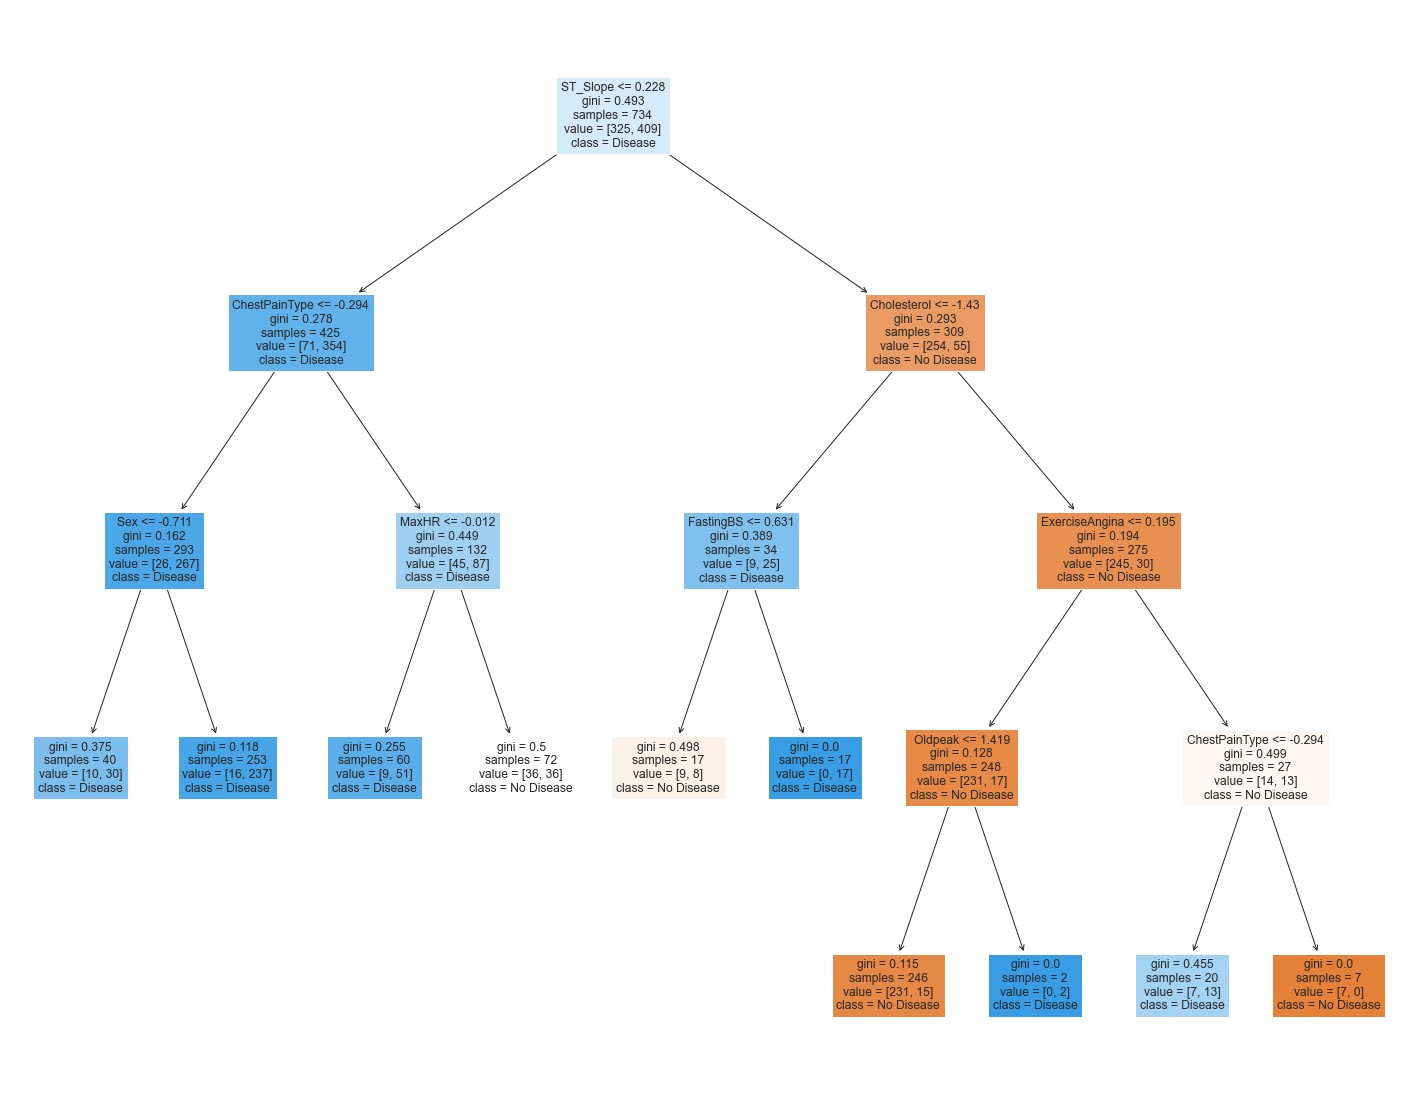

In [310]:
get_dt_graph(V3_DT_GS_best_param)

## Other Models

### Split the dataset using PCA projected data

In [5]:
from sklearn.model_selection import train_test_split
pca_X_train, pca_X_test, pca_Y_train, pca_Y_test = train_test_split(X, y, test_size=.2, random_state=41)


## Random Forest Model

In [27]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier()
RF_clf = RF_clf.fit(pca_X_train,pca_Y_train)
baseline_RF_y_pred = RF_clf.predict(pca_X_test)
print(accuracy_score(pca_Y_test, baseline_RF_y_pred))
print(RF_clf.get_params())

0.8586956521739131
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [30]:
# Preparing GridSearch 
RF_clf_parameters = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}
                     

RF_clf_for_ptuning = RandomForestClassifier()
RF_clf_GS = GridSearchCV(RF_clf_for_ptuning,                    # model
                   param_grid = RF_clf_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

RF_clf_GS = RF_clf_GS.fit(pca_X_train, pca_Y_train)
RF_clf_GS_predictions = RF_clf_GS.predict(pca_X_test)

In [31]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(pca_Y_test, RF_clf_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area Under the Curve: ", roc_auc)

#Calculate F1 Value
print(classification_report(pca_Y_test, RF_clf_GS_predictions))

#Compute Confusion Matrix
RF_clf_GS_confusion_matrix = calculate_confusion_matrix(pca_Y_test, RF_clf_GS_predictions)
RF_clf_GS_confusion_matrix

Area Under the Curve:  0.8562091503267972
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        85
           1       0.85      0.89      0.87        99

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



array([[88, 11],
       [15, 70]])

### KNN Model
Improved accuracy score of the base model from 0.8586956521739131 to 0.8906714200831848

In [11]:
from sklearn.neighbors import KNeighborsClassifier
KNN_clf = KNeighborsClassifier()
KNN_clf = KNN_clf.fit(pca_X_train,pca_Y_train)
baseline_KNN_y_pred = KNN_clf.predict(pca_X_test)
print(accuracy_score(pca_Y_test, baseline_KNN_y_pred))
print(KNN_clf.get_params())


0.8586956521739131
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


In [12]:
KNN_clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [16]:
# Preparing GridSearch 
KNN_clf_parameters = {

    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'metric' : ['minkowski','euclidean','manhattan']

}

KNN_clf_for_ptuning = KNeighborsClassifier()
KNN_clf_GS = GridSearchCV(KNN_clf_for_ptuning,                    # model
                   param_grid = KNN_clf_parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10) 

KNN_clf_GS = KNN_clf_GS.fit(pca_X_train, pca_Y_train)
KNN_clf_GS_predictions = KNN_clf_GS.predict(pca_X_test)

In [23]:

false_positive_rate, true_positive_rate, thresholds = roc_curve(pca_Y_test, KNN_clf_GS_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area Under the Curve: ", roc_auc)

#Calculate F1 Value
print(classification_report(pca_Y_test, KNN_clf_GS_predictions))

#Compute Confusion Matrix
KNN_clf_GS_confusion_matrix = calculate_confusion_matrix(pca_Y_test, KNN_clf_GS_predictions)
KNN_clf_GS_confusion_matrix

Area Under the Curve:  0.8906714200831848
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        85
           1       0.90      0.90      0.90        99

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



array([[89, 10],
       [10, 75]])

## CNN Model

In [48]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

import pandas as pd
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [44]:
pd_ori = pd.read_csv('/Users/mucheng/Desktop/heart.csv')
pd_ori.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [50]:
cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value=-99))
cat_ohe_step = ('ohe', OrdinalEncoder())
cat_steps = [cat_si_step, cat_ohe_step]

cat_pipe = Pipeline(cat_steps)
cat_cols = ['Sex','ChestPainType','RestingECG','ExerciseAngina'
,'ST_Slope']
cat_transformers = [('cat', cat_pipe, cat_cols)]

ct = ColumnTransformer(transformers=cat_transformers)
X_kdd_transformed = ct.fit_transform(pd_ori)

num_cols = ['Age', 'RestingBP', 'Cholesterol','FastingBS','MaxHR', 'Oldpeak']
num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler())
num_steps = [num_si_step, num_ss_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=num_transformers)
X_num_transformed = ct.fit_transform(pd_ori)
transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols)]
ct = ColumnTransformer(transformers=transformers)
X_strct = ct.fit_transform(pd_ori)



label_encoder = preprocessing.LabelEncoder()
labels_ori_list =pd_ori['HeartDisease'].values
label_list = label_encoder.fit_transform(labels_ori_list)


In [51]:
ds_train = TensorDataset(torch.tensor(X_strct[:700]).float(),torch.tensor(label_list[:700]))
ds_test = TensorDataset(torch.tensor(X_strct[700:]).float(),torch.tensor(label_list[700:]))

dl_train = DataLoader(ds_train,shuffle = True, batch_size = 8)
dl_test = DataLoader(ds_test,shuffle = False, batch_size = 8)

In [53]:
for features,labels in dl_train:
    print(features,labels)
    break

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  2.0000, -0.9028,  0.4109,  0.2305,
          1.8138, -0.5820, -0.8324],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.7944,  0.3028, -0.3000,
         -0.5513, -0.4641,  2.5447],
        [ 0.0000,  1.0000,  1.0000,  0.0000,  2.0000, -1.3271, -0.1295,  0.4226,
         -0.5513,  0.5184, -0.8324],
        [ 1.0000,  2.0000,  2.0000,  0.0000,  2.0000, -0.1603, -0.2376, -1.8184,
         -0.5513,  1.6973,  1.9819],
        [ 1.0000,  3.0000,  2.0000,  0.0000,  1.0000, -1.1149, -0.6699,  0.8434,
         -0.5513,  0.7149, -0.8324],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  1.0000, -0.3724,  0.6271,  0.0110,
         -0.5513, -0.4248,  0.0119],
        [ 0.0000,  1.0000,  1.0000,  0.0000,  2.0000, -1.7514, -0.6699,  0.5598,
         -0.5513, -0.2676, -0.8324],
        [ 1.0000,  0.0000,  1.0000,  0.0000,  1.0000, -0.5846, -1.4265,  0.5872,
          1.8138, -1.0536, -0.8324]]) tensor([0, 1, 0, 1, 1, 1, 0, 1])


In [55]:
import torch.nn as nn
import torch.nn.functional as F

class NetHeartCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(5, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11, 50)
        self.fc2 = nn.Linear(9, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1,5,10)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_heart_cnn = NetHeartCnn().to(device)
net_heart_cnn(features).shape

torch.Size([8, 2])

In [56]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_heart_dnn.parameters(), lr=1e-3)

In [57]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [58]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

### Evaluations

In [59]:
epochs = 10
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
# model_eg = net_heart_cnn
model_eg = net_heart_dnn
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dl_train, model_eg, loss_fn, optimizer)
    train_correct,train_loss = test(dl_train, model_eg, loss_fn)
    test_correct,test_loss = test(dl_test, model_eg, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.660633  [    0/  700]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.426962 

Test Error: 
 Accuracy: 77.1%, Avg loss: 0.503091 

Epoch 2
-------------------------------
loss: 0.331384  [    0/  700]
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.340343 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.455253 

Epoch 3
-------------------------------
loss: 0.324536  [    0/  700]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.318079 

Test Error: 
 Accuracy: 78.4%, Avg loss: 0.470230 

Epoch 4
-------------------------------
loss: 0.103604  [    0/  700]
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.304158 

Test Error: 
 Accuracy: 78.9%, Avg loss: 0.504156 

Epoch 5
-------------------------------
loss: 0.230599  [    0/  700]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.282013 

Test Error: 
 Accuracy: 77.1%, Avg loss: 0.498876 

Epoch 6
-------------------------------
loss: 0.060571  [    0/  700]
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.274344 

Test Err

#### Conclusion: KNN(89%) > Random Forest (86%) > other Decision Tree models with Variations (83%) > CNN: 77.1%